## Content:
- **[Part 1](#part1)- Importing the data set, packages used**
- **[Part 2](#part2)- Preprocessing Data**
- **[Part 3](#part3) -  Linear Regression**
- **[Part 4](#part4) -  Lasso Regression**
- **[Part 5](#part5) -  Linear Regression with less features**
- **[Part 6](#part6) - Regression with ANN**
- **[Part 7](#part7) - Regression with two Hidden Layers**
- **[Part 8](#part8) - Regression with three Hidden Layers**
- **[Part 9](#part9) - Adding noise to data**
- **[Part 10](#part10) - ANN with noise**


The problem can also be viewed as a regression problem, since categories can be ranked we can use regression and then map the prediction result to a category. Our intuition is that by making the model learn classification of the categories using regression might improve our results.

[Back to top](#Content:)


<a id='part1'></a>

# Part 1 -  Importing the data set

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
%matplotlib inline

In [2]:
random.seed(0)

In [3]:
# Loading Dataset
df = pd.read_csv("healthcare/train_data.csv", na_values=['NA', '?'])

In [4]:
# Dropping na values for 
df = df.dropna()

In [5]:
# Dropping case_id
df.drop(['case_id'], axis=1, inplace=True)

[Back to top](#Content:)


<a id='part2'></a>

# Part 2 -  Preprocessing Data

### Hot Encoded Data

In [6]:
# Function to hot encode the column with name : name for dataframe df
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True) 

In [52]:
from sklearn.preprocessing import LabelEncoder 
# Columns where we use Label Encoding
le_string_columns = ['Severity of Illness', 'Age' ]
# Columns where we use One Hot Encoding
dummies_string_columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code',  'Type of Admission']
encoder = LabelEncoder()

## label_encoded data
Xe = df.drop(['Stay', 'patientid'], axis=1)
Xe['Severity of Illness']= Xe['Severity of Illness'].map({'Minor': 0,  'Moderate': 1,'Extreme': 2})
Xe['Age'] = encoder.fit_transform(Xe['Age'])

ye = df['Stay']
ye = encoder.fit_transform(ye)

for column in dummies_string_columns :
    encode_text_dummy(Xe, column)
    

### Scaling and splitting Data

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X = Xe.values
y = ye
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
for i in range(X_train.shape[1]) :
    X_train[:,i]= scaler.fit_transform(X_train[:,i].reshape(-1, 1))[:,0]
    X_test[:,i] = scaler.transform(X_test[:,i].reshape(-1, 1))[:,0]

### Scoring

In [9]:
K = 10 # Num of Classes 
# Classes can be ranked here from 0-10
def score(pred, target):
    error = (np.mean(np.abs(pred-target)))/K
    score = 1 - error
    return score

# Models

We start by a base model, models used here are that are most adapted to the nature of the problem :
- Linear Regression
- Lasso Regression
- One Hidden Layer ANN
- Two Hidden Layer ANN


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

[Back to top](#Content:)


<a id='part3'></a>

# Part 3 -  Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression

### Fitting Linear Regression on the whole dataset

In [54]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [55]:
y_pred = model.predict(X)


In [56]:
print('y_pred.max()',y_pred.max() )
print('y_pred.min()',y_pred.min() )

y_pred.max() 23.563992639767644
y_pred.min() -1.3908390607728123


The range of y is from 0 to 10, we can see that the regression have values that are out of bound. We write a function to map the prediction to categories.

In [33]:
def cat(x):
    cat_x = np.maximum(x, 0)
    cat_x = np.minimum(cat_x, 10)
    cat_x = np.floor(cat_x)
    cat_x = cat_x.astype(int)
    return cat_x

In [57]:
from sklearn.metrics import accuracy_score
K = 10
y_pred = cat(y_pred)
accuracy = accuracy_score(y_pred, y)
score = 1 - (np.mean(np.abs(y_pred-y)))/K
print(f'Accuracy : %.3f' % accuracy)
print(f'Score : %.4f' % score)

Accuracy : 0.305
Score : 0.8784


We can see that the score is high compared to accuracy if we take into account the previous results we got, this is makes sense since regression optimise for the distance between categories here which is equivalent to optimising for the score.

### Confusion matrix

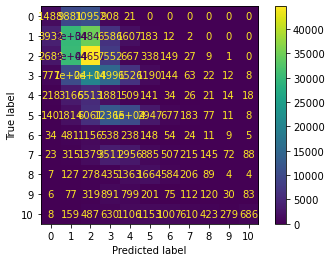

In [58]:
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

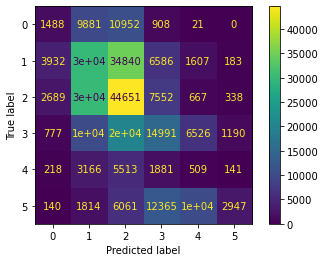

In [59]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

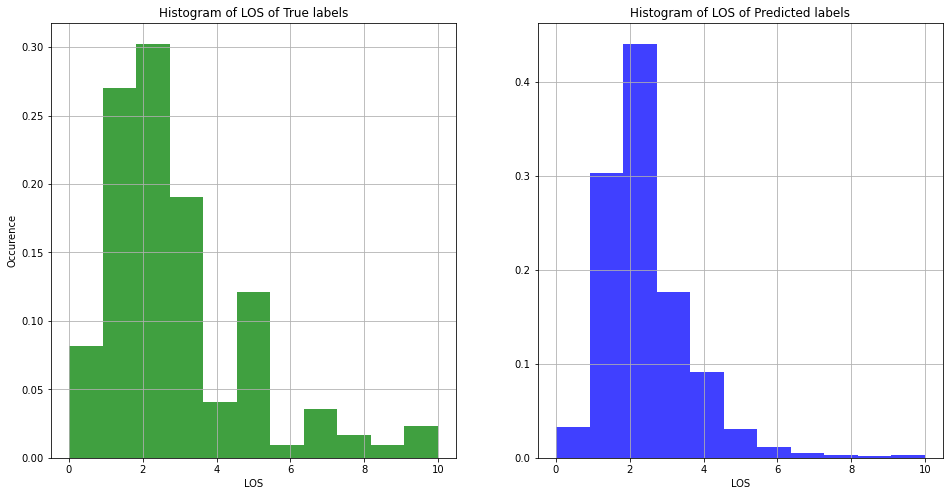

In [60]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)
ax1.grid(True)
ax1.hist(y, bins=11, density=True, facecolor='g', alpha=0.75)
ax1.set_title('Histogram of LOS of True labels')
ax1.set_xlabel('LOS')
ax1.set_ylabel('Occurence')

ax2.grid(True)
ax2.hist(y_pred, bins=11,  density=True, facecolor='b', alpha=0.75)
ax2.set_title('Histogram of LOS of Predicted labels')
ax2.set_xlabel('LOS')



plt.show()

Linear regression suffer from different problems, it also over predicts cat 1 and 2 but it neglects cat 5 

### Fitting Linear Regression on the training dataset

In [41]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('y_pred.max()',y_pred.max() )
print('y_pred.min()',y_pred.min() )

y_pred.max() 23.23759422665279
y_pred.min() -1.1959995233472132


In [43]:
from sklearn.metrics import mean_squared_error

y_pred = cat(y_pred)

accuracy = accuracy_score(y_pred, y_test)
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
error = np.sqrt(mean_squared_error(y_pred,y_test))
mean = np.mean(y_test)

print('mean y_test: %.2f' % mean)
print('RMSE : %.2f' % error)
print(f'Accuracy : %.3f' % accuracy)
print(f'Score : %.4f' % score)

mean y_test: 2.69
RMSE : 1.76
Accuracy : 0.305
Score : 0.8789


We have similar results to those we get when we fit on the whole dataset. A question we might ask is if there are any features that prevents us from getting better results. We will explore that using Lasso regression.

[Back to top](#Content:)


<a id='part4'></a>

# Part 4 -  Lasso Regression

It doesnt make much different weather we fit the regression on the whole dataset or only training set, we will try with training dataset

In [61]:
from sklearn.linear_model import Lasso
# Create linear regression
regressor = Lasso(alpha=0.1)

# Fit/train LASSO
regressor.fit(X_train,y_train)
# Predict
y_pred = regressor.predict(X_test)
print('y_pred.max()',y_pred.max() )
print('y_pred.min()',y_pred.min() )

y_pred.max() 20.7674567645083
y_pred.min() 0.40156519599156404


In [62]:
y_pred = cat(y_pred)

accuracy = accuracy_score(y_pred, y_test)
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
error = np.sqrt(mean_squared_error(y_pred,y_test))
mean = np.mean(y_test)

print('mean y_test: %.2f' % mean)
print('RMSE : %.2f' % error)
print(f'Accuracy : %.3f' % accuracy)
print(f'Score : %.4f' % score)

mean y_test: 2.69
RMSE : 1.80
Accuracy : 0.314
Score : 0.8776


Results are slightly better than regression, but here we are looking for features to keep/drop

In [63]:
# Function to plot Lasso coef
def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': np.abs(coef)  }, index = names )
    r = r.sort_values(by=['positive'], ascending=False)
    display(r)
    print("Intercept: {}".format(intercept))
    #plt.xlabel('covariate coefficient')
    #r['coef'].plot(kind='barh')

In [64]:
names = list(Xe.columns.values)
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)

,coef,positive
Visitors with Patient,1.094805,1.094805
Ward_Type-S,0.210604,0.210604
Ward_Type-Q,-0.155312,0.155312
Available Extra Rooms in Hospital,-0.133706,0.133706
Severity of Illness,0.116297,0.116297
Type of Admission-Emergency,-0.062019,0.062019
Type of Admission-Trauma,0.060036,0.060036
Ward_Facility_Code-C,-0.052824,0.052824
Ward_Type-P,-0.042891,0.042891
Hospital_type_code-a,-0.008528,0.008528


Intercept: 2.698585899789245


It seems many of the feature are eliminated by Lasso, following the results we will keep only thease feature for our next LinearRegression model :
- Visitors
- Ward Type 
- Available extra rooms
- Severity of Illness
- Type of Admission


[Back to top](#Content:)


<a id='part5'></a>

# Part 5 -  Linear Regression with reduced features

## Preparing new Data

In [66]:
features = ['Visitors with Patient', 'Ward_Type', 'Available Extra Rooms in Hospital', 'Severity of Illness', 'Type of Admission']

# Columns where we use One Hot Encoding
dummies_string_columns = [ 'Ward_Type', 'Type of Admission']

df_reg = df.copy()
Xreg = df_reg[features]
Xreg['Severity of Illness']= Xreg['Severity of Illness'].map({'Minor': 0,  'Moderate': 1,'Extreme': 2})

yreg = y

for column in dummies_string_columns :
    encode_text_dummy(Xreg, column)

/Users/baraa/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/baraa/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
# Scaling data
Xreg = Xreg.values
Xreg_train, Xreg_test, yreg_train, yreg_test = train_test_split(Xreg, yreg, test_size=0.25, random_state=0)
for i in range(Xreg_train.shape[1]) :
    Xreg_train[:,i]= scaler.fit_transform(Xreg_train[:,i].reshape(-1, 1))[:,0]
    Xreg_test[:,i] = scaler.transform(Xreg_test[:,i].reshape(-1, 1))[:,0]

### Fitting data on training set

In [71]:
model = LinearRegression()
model.fit(Xreg_train, yreg_train)
yreg_pred = model.predict(Xreg_test)
print('y_pred.max()',yreg_pred.max() )
print('y_pred.min()',yreg_pred.min() )

y_pred.max() 25.446243286132812
y_pred.min() -0.0618743896484375


In [72]:
yreg_pred = cat(yreg_pred)

accuracy = accuracy_score(yreg_pred, yreg_test)
score = 1 - (np.mean(np.abs(yreg_pred-yreg_test)))/K
error = np.sqrt(mean_squared_error(yreg_pred,yreg_test))
mean = np.mean(yreg_test)

print('mean y_test: %.2f' % mean)
print('RMSE : %.2f' % error)
print(f'Accuracy : %.3f' % accuracy)
print(f'Score : %.4f' % score)

mean y_test: 2.69
RMSE : 1.92
Accuracy : 0.297
Score : 0.8688


It seems this is didnt help much.Now we move to ANN.

# Regression with ANN 

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping


[Back to top](#Content:)


<a id='part6'></a>

# Part 6 -   Regression with one Hidden Layer

### Model


In [74]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='loss', min_delta=1e-2, patience=5, verbose=1, mode='auto')
r = model.fit(X_train,y_train,verbose=1,epochs=100)


2021-12-18 16:14:18.264211: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-18 16:14:18.265140: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Train on 235344 samples
Epoch 1/100
235344/235344 [==============================] - 10s 42us/sample - loss: 2.7710s - loss: 2.7
Epoch 2/100
235344/235344 [==============================] - 9s 40us/sample - loss: 2.6096
Epoch 3/100
235344/235344 [==============================] - 9s 40us/sample - loss: 2.5558
Epoch 4/100
235344/235344 [==============================] - 9s 39us/sample - loss: 2.5248
Epoch 5/100
235344/235344 [==============================] - 9s 39us/sample - loss: 2.5098
Epoch 6/100
235344/235344 [==============================] - 9s 39us/sample - loss: 2.4995
Epoch 7/100
235344/235344 [==============================] - 10s 41us/sample - loss: 2.4901
Epoch 8/100
235344/235344 [==============================] - 10s 41us/sample - loss: 2.4756
Epoch 9/100
235344/235344 [==============================] - 9s 40us/sample - loss: 2.4683
Epoch 10/100
235344/235344 [==============================] - 10s 41us/sample - loss: 2.4579
Epoch 11/100
235344/235344 [====================

235344/235344 [==============================] - 9s 39us/sample - loss: 2.3659
Epoch 89/100
235344/235344 [==============================] - 9s 39us/sample - loss: 2.3651
Epoch 90/100
235344/235344 [==============================] - 9s 39us/sample - loss: 2.3628
Epoch 91/100
235344/235344 [==============================] - 9s 39us/sample - loss: 2.3610
Epoch 92/100
235344/235344 [==============================] - 9s 39us/sample - loss: 2.3619
Epoch 93/100
235344/235344 [==============================] - 9s 39us/sample - loss: 2.36190s - loss: 2
Epoch 94/100
235344/235344 [==============================] - 9s 39us/sample - loss: 2.3600
Epoch 95/100
235344/235344 [==============================] - 9s 40us/sample - loss: 2.3608
Epoch 96/100
235344/235344 [==============================] - 9s 39us/sample - loss: 2.3602
Epoch 97/100
235344/235344 [==============================] - 9s 40us/sample - loss: 2.3592
Epoch 98/100
235344/235344 [==============================] - 9s 40us/sample - lo

In [75]:
ypred = model.predict(X_test)
print('y_pred.max()',y_pred.max() )
print('y_pred.min()',y_pred.min() )

y_pred.max() 10
y_pred.min() 0


In [78]:
np.unique(y_pred)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

As opposed to simple regression, the neural net learn the values very well.

In [79]:
y_pred = cat(y_pred)

accuracy = accuracy_score(y_pred, y_test)
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
error = np.sqrt(mean_squared_error(y_pred,y_test))
mean = np.mean(y_test)

print('mean y_test: %.2f' % mean)
print('RMSE : %.2f' % error)
print(f'Accuracy : %.3f' % accuracy)
print(f'Score : %.4f' % score)

mean y_test: 2.69
RMSE : 1.80
Accuracy : 0.314
Score : 0.8776


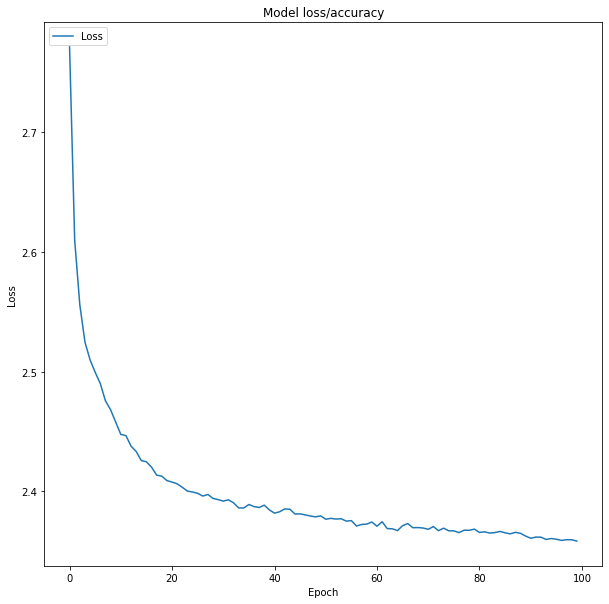

In [84]:
# Plotting
plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')
plt.show()

Loss converge maybe 50 epochs is enough

## Confusion matrix

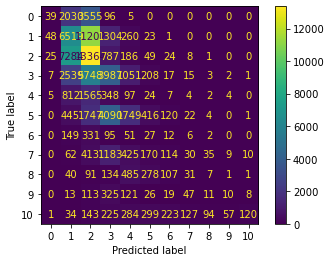

In [85]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

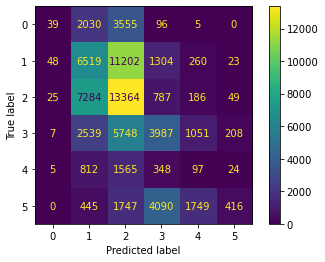

In [86]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();


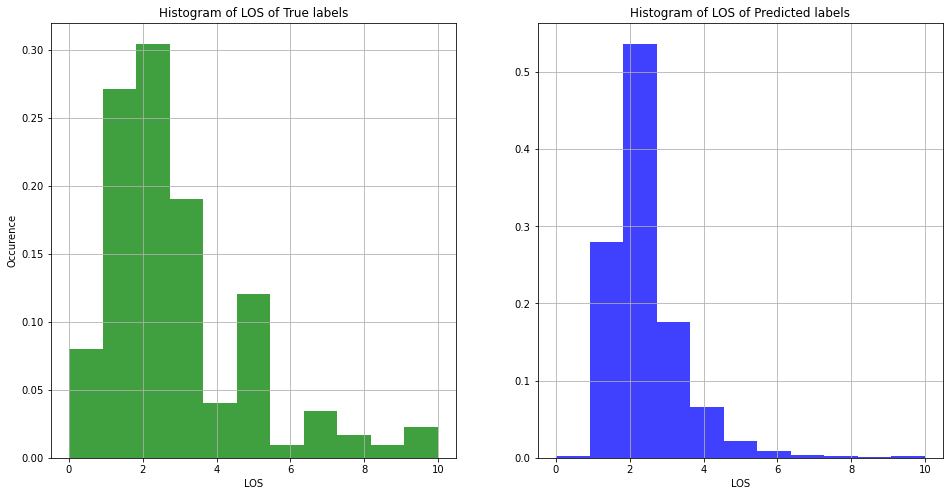

In [89]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)
ax1.grid(True)
ax1.hist(y_test, bins=11,  density=True, facecolor='g', alpha=0.75)
ax1.set_title('Histogram of LOS of True labels')
ax1.set_xlabel('LOS')
ax1.set_ylabel('Occurence')

ax2.grid(True)
ax2.hist(y_pred, bins=11,  density=True, facecolor='b', alpha=0.75)
ax2.set_title('Histogram of LOS of Predicted labels')
ax2.set_xlabel('LOS')



plt.show()

When we explore the histogram, the model shows also the same issues showed by linear regression

[Back to top](#Content:)


<a id='part7'></a>

# Part 7 -   Regression with two Hidden Layers

In [94]:
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(24, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='loss', min_delta=1e-2, patience=5, verbose=1, mode='auto')

r = model.fit(X_train,y_train,callbacks=[monitor],validation_split=0.25,verbose=1,epochs=50)

Train on 176508 samples, validate on 58836 samples
Epoch 1/50
176508/176508 [==============================] - 7s 41us/sample - loss: 2.7436 - val_loss: 2.5413
Epoch 2/50
176508/176508 [==============================] - 6s 36us/sample - loss: 2.5259 - val_loss: 2.4900
Epoch 3/50
176508/176508 [==============================] - 6s 36us/sample - loss: 2.4966 - val_loss: 2.4818
Epoch 4/50
176508/176508 [==============================] - 7s 37us/sample - loss: 2.4830 - val_loss: 2.4596
Epoch 5/50
176508/176508 [==============================] - 7s 37us/sample - loss: 2.4717 - val_loss: 2.4557
Epoch 6/50
176508/176508 [==============================] - 6s 36us/sample - loss: 2.4613 - val_loss: 2.4481
Epoch 7/50
176508/176508 [==============================] - 6s 36us/sample - loss: 2.4543 - val_loss: 2.4411
Epoch 8/50
176508/176508 [==============================] - 6s 35us/sample - loss: 2.4487 - val_loss: 2.4402
Epoch 9/50
176508/176508 [==============================] - 6s 35us/sample - 

In [95]:
ypred = model.predict(X_test)
print('y_pred.max()',y_pred.max() )
print('y_pred.min()',y_pred.min() )
print(np.unique(y_pred))

y_pred.max() 10
y_pred.min() 0
[ 0  1  2  3  4  5  6  7  8  9 10]


In [96]:
y_pred = cat(y_pred)

accuracy = accuracy_score(y_pred, y_test)
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
error = np.sqrt(mean_squared_error(y_pred,y_test))
mean = np.mean(y_test)

print('mean y_test: %.2f' % mean)
print('RMSE : %.2f' % error)
print(f'Accuracy : %.3f' % accuracy)
print(f'Score : %.4f' % score)

mean y_test: 2.69
RMSE : 1.80
Accuracy : 0.314
Score : 0.8776


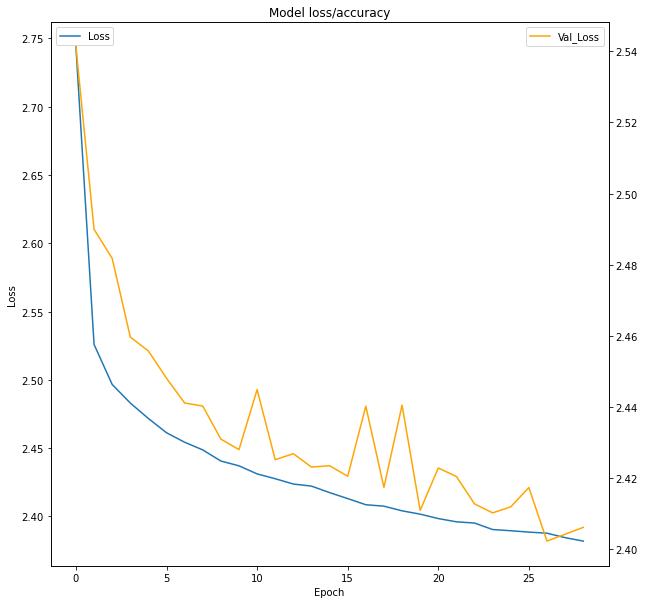

In [97]:
# Plotting
plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')


plt2=plt.twinx()
plt2.plot(r.history['val_loss'], color='orange')
plt2.legend(['Val_Loss'], loc='upper right')

plt.show()

## Confusion Matrix

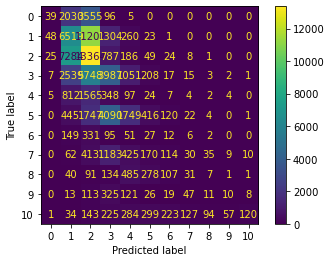

In [98]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

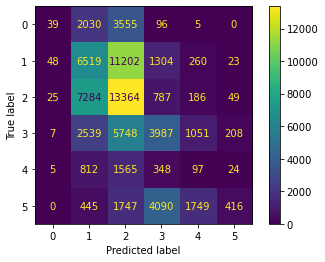

In [99]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();


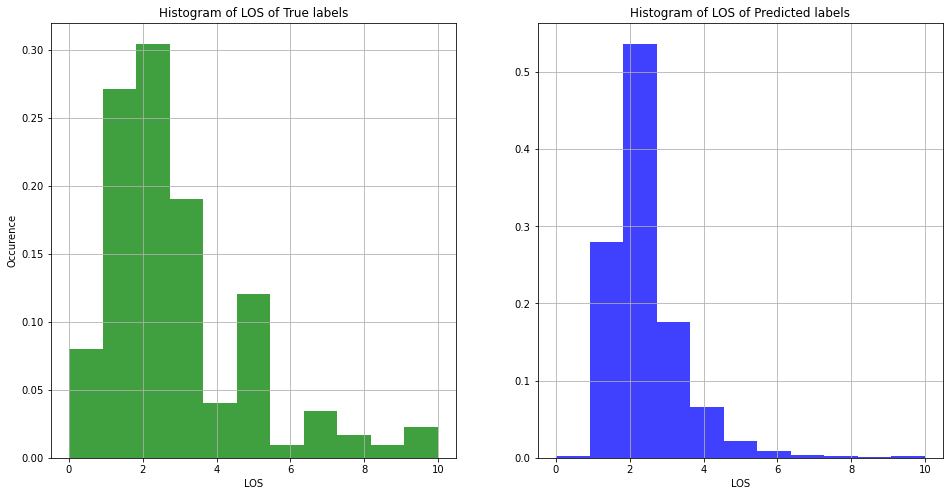

In [100]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)
ax1.grid(True)
ax1.hist(y_test, bins=11,  density=True, facecolor='g', alpha=0.75)
ax1.set_title('Histogram of LOS of True labels')
ax1.set_xlabel('LOS')
ax1.set_ylabel('Occurence')

ax2.grid(True)
ax2.hist(y_pred, bins=11,  density=True, facecolor='b', alpha=0.75)
ax2.set_title('Histogram of LOS of Predicted labels')
ax2.set_xlabel('LOS')



plt.show()

Same problem again

[Back to top](#Content:)


<a id='part8'></a>

# Part 8 -   Regression with three Hidden Layers

## Model

In [102]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='loss', min_delta=1e-2, patience=5, verbose=1, mode='auto')
r = model.fit(X_train,y_train,callbacks=[monitor],validation_split=0.25,verbose=1,epochs=50)

Train on 176508 samples, validate on 58836 samples
Epoch 1/50
176508/176508 [==============================] - 15s 88us/sample - loss: 3.0488 - val_loss: 2.5501
Epoch 2/50
176508/176508 [==============================] - 15s 84us/sample - loss: 2.6476 - val_loss: 2.5415
Epoch 3/50
176508/176508 [==============================] - 15s 84us/sample - loss: 2.5945 - val_loss: 2.4825
Epoch 4/50
176508/176508 [==============================] - 15s 84us/sample - loss: 2.5694 - val_loss: 2.4949
Epoch 5/50
176508/176508 [==============================] - 15s 84us/sample - loss: 2.5513 - val_loss: 2.6150
Epoch 6/50
176508/176508 [==============================] - 16s 89us/sample - loss: 2.5320 - val_loss: 2.4949
Epoch 7/50
176508/176508 [==============================] - 17s 98us/sample - loss: 2.5234 - val_loss: 2.4818
Epoch 8/50
176508/176508 [==============================] - 15s 86us/sample - loss: 2.5164 - val_loss: 2.5357
Epoch 9/50
176508/176508 [==============================] - 15s 85us/

In [103]:
ypred = model.predict(X_test)
print('y_pred.max()',y_pred.max() )
print('y_pred.min()',y_pred.min() )
print(np.unique(y_pred))

y_pred.max() 10
y_pred.min() 0
[ 0  1  2  3  4  5  6  7  8  9 10]


In [104]:
y_pred = cat(y_pred)

accuracy = accuracy_score(y_pred, y_test)
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
error = np.sqrt(mean_squared_error(y_pred,y_test))
mean = np.mean(y_test)

print('mean y_test: %.2f' % mean)
print('RMSE : %.2f' % error)
print(f'Accuracy : %.3f' % accuracy)
print(f'Score : %.4f' % score)

mean y_test: 2.69
RMSE : 1.80
Accuracy : 0.314
Score : 0.8776


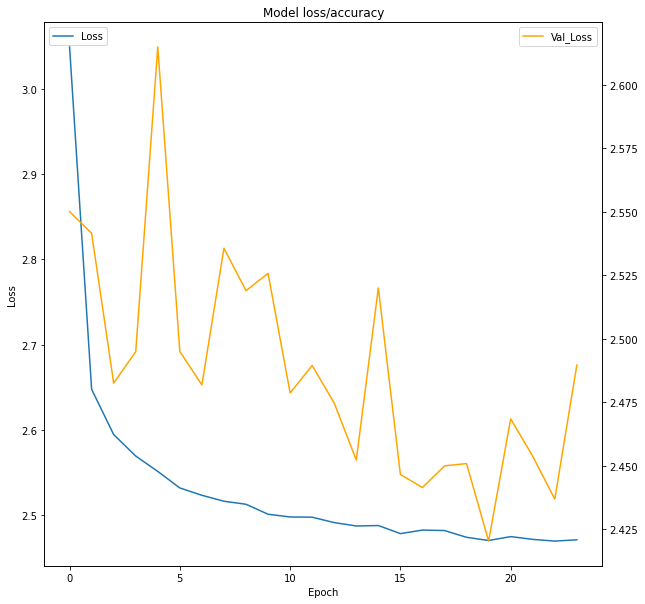

In [105]:
# Plotting
plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')


plt2=plt.twinx()
plt2.plot(r.history['val_loss'], color='orange')
plt2.legend(['Val_Loss'], loc='upper right')

plt.show()

### Confusion Matrix

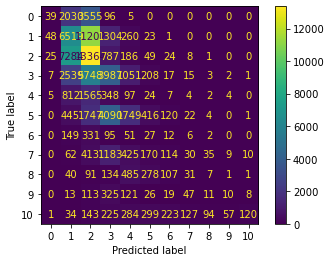

In [106]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

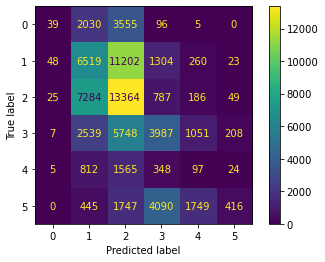

In [107]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

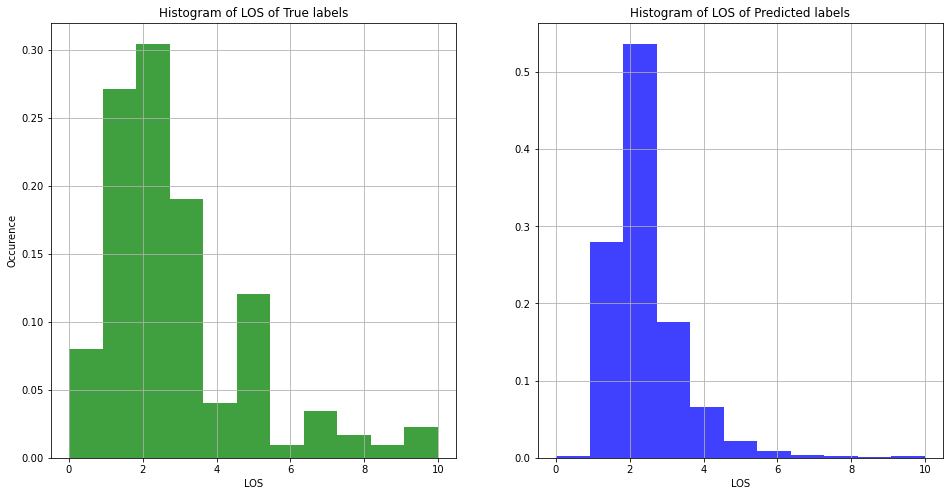

In [109]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)
ax1.grid(True)
ax1.hist(y_test, bins=11, density=True, facecolor='g', alpha=0.75)
ax1.set_title('Histogram of LOS of True labels')
ax1.set_xlabel('LOS')
ax1.set_ylabel('Occurence')

ax2.grid(True)
ax2.hist(y_pred, bins=11,  density=True, facecolor='b', alpha=0.75)
ax2.set_title('Histogram of LOS of Predicted labels')
ax2.set_xlabel('LOS')



plt.show()

Nothing new to report, in overall all the models seems to be overfitting the predictions of category 2.

We will explore the idea of adding noise to the data and then performing regression

[Back to top](#Content:)


<a id='part9'></a>

# Part 9 -   Adding noise to data

In [143]:
# Creating noise
noise = np.abs(np.random.randn(len(y)))
noise = 2*noise / noise.max()
noise.mean()


0.3395179812206264

In [146]:
# noisy target
yn = y + noise

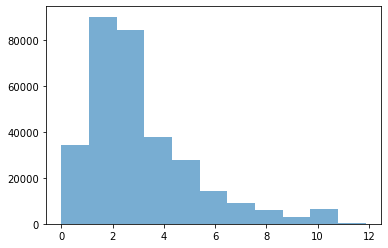

In [148]:
plt.hist(yn, bins=11, alpha=0.6);

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, yn, test_size=0.25, random_state=0)
for i in range(X_train.shape[1]) :
    X_train[:,i]= scaler.fit_transform(X_train[:,i].reshape(-1, 1))[:,0]
    X_test[:,i] = scaler.transform(X_test[:,i].reshape(-1, 1))[:,0]

[Back to top](#Content:)


<a id='part10'></a>

# Part 10 -   ANN with noise

## One hidden layer

In [150]:
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='loss', min_delta=1e-2, patience=5, verbose=1, mode='auto')

r = model.fit(X_train,y_train,callbacks=[monitor],validation_split=0.25,verbose=1,epochs=50)

Train on 176508 samples, validate on 58836 samples
Epoch 1/50
176508/176508 [==============================] - 6s 33us/sample - loss: 3.1170 - val_loss: 2.7460
Epoch 2/50
176508/176508 [==============================] - 5s 30us/sample - loss: 2.7280 - val_loss: 2.6805
Epoch 3/50
176508/176508 [==============================] - 5s 30us/sample - loss: 2.6737 - val_loss: 2.6415
Epoch 4/50
176508/176508 [==============================] - 5s 30us/sample - loss: 2.6416 - val_loss: 2.6019
Epoch 5/50
176508/176508 [==============================] - 5s 30us/sample - loss: 2.6213 - val_loss: 2.6277
Epoch 6/50
176508/176508 [==============================] - 6s 32us/sample - loss: 2.6082 - val_loss: 2.5973
Epoch 7/50
176508/176508 [==============================] - 6s 31us/sample - loss: 2.6019 - val_loss: 2.5787
Epoch 8/50
176508/176508 [==============================] - 5s 31us/sample - loss: 2.5971 - val_loss: 2.5827
Epoch 9/50
176508/176508 [==============================] - 6s 32us/sample - 

In [151]:
ypred = model.predict(X_test)
print('y_pred.max()',y_pred.max() )
print('y_pred.min()',y_pred.min() )

y_pred.max() 10
y_pred.min() 0


In [158]:
y_pred = cat(y_pred)

accuracy = accuracy_score(y_pred, cat(y_test))
score = 1 - (np.mean(np.abs(y_pred-cat(y_test))))/K
error = np.sqrt(mean_squared_error(y_pred,cat(y_test)))
mean = np.mean(cat(y_test))

print('mean y_test: %.2f' % mean)
print('RMSE : %.2f' % error)
print(f'Accuracy : %.3f' % accuracy)
print(f'Score : %.4f' % score)

mean y_test: 2.71
RMSE : 1.81
Accuracy : 0.311
Score : 0.8767


## Accuracy and loss plots

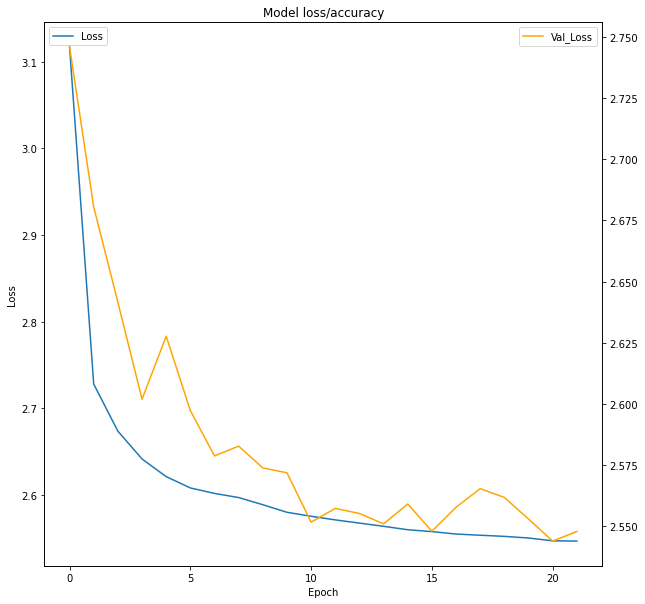

In [159]:
# Plotting
plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')


plt2=plt.twinx()
plt2.plot(r.history['val_loss'], color='orange')
plt2.legend(['Val_Loss'], loc='upper right')

plt.show()

## Confusion matrix

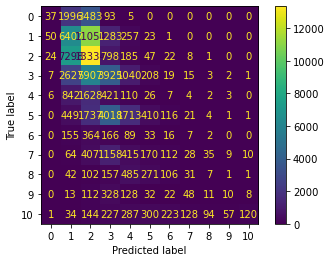

In [161]:
cm = confusion_matrix(cat(y_test), y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

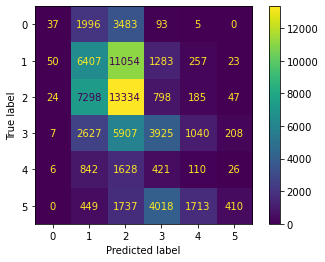

In [162]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(cat(y_test), y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

## Histograms

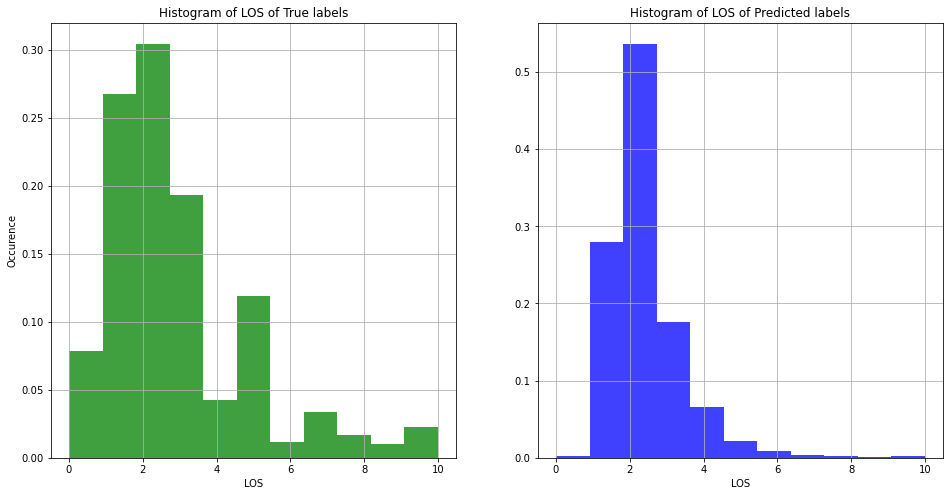

In [163]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)
ax1.grid(True)
ax1.hist(cat(y_test), bins=11, density=True, facecolor='g', alpha=0.75)
ax1.set_title('Histogram of LOS of True labels')
ax1.set_xlabel('LOS')
ax1.set_ylabel('Occurence')

ax2.grid(True)
ax2.hist(y_pred, bins=11,  density=True, facecolor='b', alpha=0.75)
ax2.set_title('Histogram of LOS of Predicted labels')
ax2.set_xlabel('LOS')



plt.show()

Adding noise didn't help that much.

## Model two hidden layers

In [164]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='loss', min_delta=1e-2, patience=5, verbose=1, mode='auto')

r = model.fit(X_train,y_train,callbacks=[monitor],validation_split=0.25,verbose=1,epochs=50)

Train on 176508 samples, validate on 58836 samples
Epoch 1/50
176508/176508 [==============================] - 11s 61us/sample - loss: 2.8422 - val_loss: 2.6353
Epoch 2/50
176508/176508 [==============================] - 11s 60us/sample - loss: 2.6085 - val_loss: 2.5506
Epoch 3/50
176508/176508 [==============================] - 10s 59us/sample - loss: 2.5544 - val_loss: 2.5341
Epoch 4/50
176508/176508 [==============================] - 10s 59us/sample - loss: 2.5333 - val_loss: 2.5171
Epoch 5/50
176508/176508 [==============================] - 10s 58us/sample - loss: 2.5169 - val_loss: 2.5041
Epoch 6/50
176508/176508 [==============================] - 10s 58us/sample - loss: 2.5029 - val_loss: 2.4987
Epoch 7/50
176508/176508 [==============================] - 10s 59us/sample - loss: 2.4894 - val_loss: 2.4864
Epoch 8/50
176508/176508 [==============================] - 10s 58us/sample - loss: 2.4836 - val_loss: 2.4802
Epoch 9/50
176508/176508 [==============================] - 10s 56us/

In [165]:
ypred = model.predict(X_test)
print('y_pred.max()',y_pred.max() )
print('y_pred.min()',y_pred.min() )

y_pred.max() 10
y_pred.min() 0


In [166]:
y_pred = cat(y_pred)

accuracy = accuracy_score(y_pred, cat(y_test))
score = 1 - (np.mean(np.abs(y_pred-cat(y_test))))/K
error = np.sqrt(mean_squared_error(y_pred,cat(y_test)))
mean = np.mean(cat(y_test))

print('mean y_test: %.2f' % mean)
print('RMSE : %.2f' % error)
print(f'Accuracy : %.3f' % accuracy)
print(f'Score : %.4f' % score)

mean y_test: 2.71
RMSE : 1.81
Accuracy : 0.311
Score : 0.8767


## Accuracy and loss plots

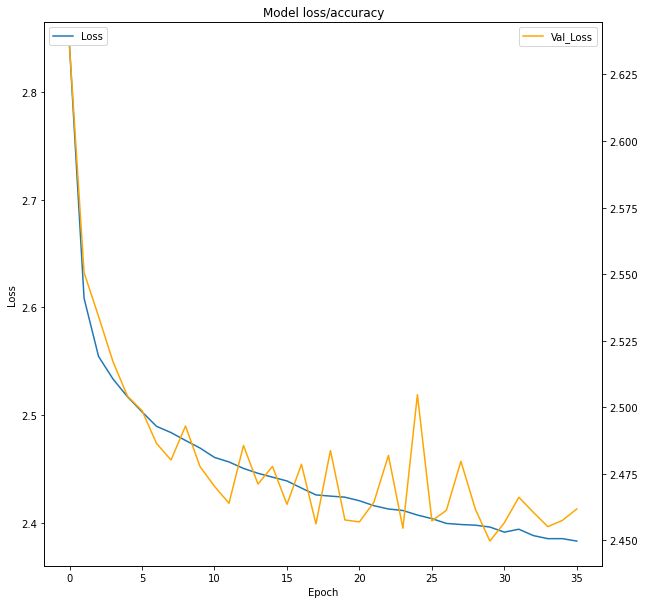

In [167]:
# Plotting
plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')


plt2=plt.twinx()
plt2.plot(r.history['val_loss'], color='orange')
plt2.legend(['Val_Loss'], loc='upper right')

plt.show()

## Confusion matrix

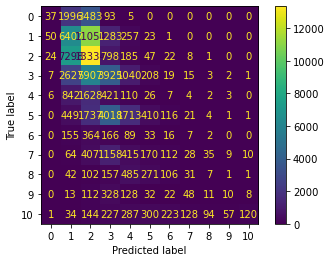

In [168]:
cm = confusion_matrix(cat(y_test), y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

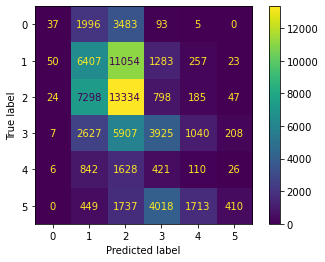

In [169]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(cat(y_test), y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

## Histogram

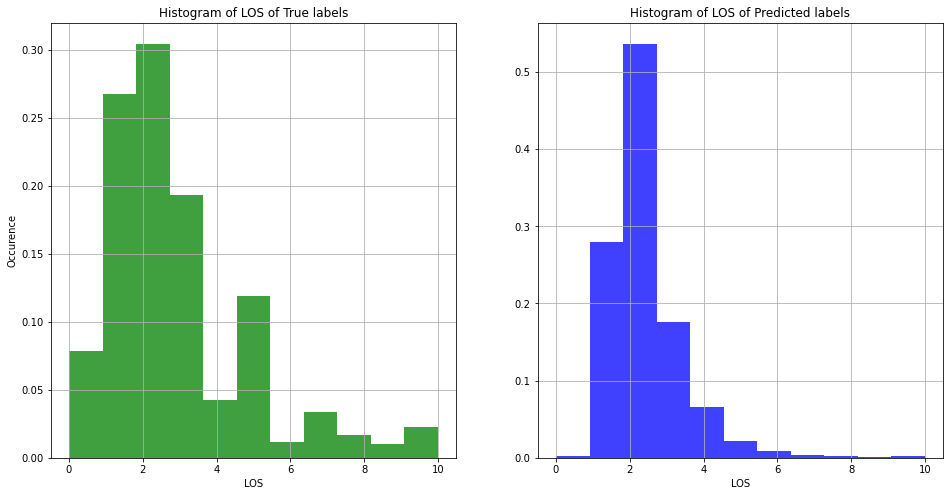

In [170]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)
ax1.grid(True)
ax1.hist(cat(y_test), bins=11, density=True, facecolor='g', alpha=0.75)
ax1.set_title('Histogram of LOS of True labels')
ax1.set_xlabel('LOS')
ax1.set_ylabel('Occurence')

ax2.grid(True)
ax2.hist(y_pred, bins=11,  density=True, facecolor='b', alpha=0.75)
ax2.set_title('Histogram of LOS of Predicted labels')
ax2.set_xlabel('LOS')



plt.show()